In [1]:
import geopandas as gpd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import xml.etree.ElementTree as ET

import pandas as pd
from shapely.geometry import Point
import os
from sklearn.preprocessing import PolynomialFeatures

import matsim
import pandas as pd
from collections import defaultdict

from shapely.geometry import box
import logging
import calendar
import datetime

import ast
from textwrap import wrap
rng = np.random.default_rng(seed=42)

import shapely


# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [2]:

# ==============================================================================
# 📦 DATA LOADING: Street networks and parcel shipment data (DHL, Hermes)
# ------------------------------------------------------------------------------

logging.info("Reading input data...")

# Define coordinate reference system (ETRS89 / UTM zone 32N)
crs = 25832

# Input folder path
folder = "input/"

# File names
matsim_network_xml_file = "multimodalNetwork.xml"           # MATSim network file (XML)
dhl_streets_file = "dhl2streets_2021.shp"                   # DHL street segments with daily volume
hermes_file = "Hermes_PLZ-Menge_2019-2021.csv"              # Hermes PLZ-level volume

# -------------------------------------------------------------------------------
# 1. Load MATSim street network and convert to GeoDataFrame
# -------------------------------------------------------------------------------
matsim_gdf = matsim.read_network(folder + matsim_network_xml_file).as_geo()

# -------------------------------------------------------------------------------
# 2. Load DHL street segments (Shapefile), reproject and rename daily volume column
# -------------------------------------------------------------------------------

# Liste der Sonderstraßen (z. B. Lager)
special_streets = ["Am Berkhopsfeld", "Stockholmer Allee"]
dhl_streets_gdf = gpd.read_file(folder + dhl_streets_file, encoding='UTF-8')
dhl_streets_gdf = dhl_streets_gdf.to_crs(crs)
dhl_streets_gdf = dhl_streets_gdf.rename(columns={'tagesschni': 'dhl_tag'})  # 'dhl_tag' = daily DHL volume
dhl_streets_gdf = dhl_streets_gdf[~dhl_streets_gdf["name"].isin(special_streets)]
dhl_special_streets_gdf = dhl_streets_gdf[dhl_streets_gdf["name"].isin(special_streets)]

# -------------------------------------------------------------------------------
# 3. Load Hermes PLZ-level shipment data and estimate daily volume for 2021
# -------------------------------------------------------------------------------
hermes_df = pd.read_csv(folder + hermes_file, encoding='utf-8', sep=';', thousands='.')

# Estimate 2021 volume usin  per weekday (≈ 26 delivery weeks)
hermes_df['hermes_tag'] = round(
    (hermes_df['2020'] + (8 / 12) * (hermes_df['2021'] - hermes_df['2020'])) / 26
)

logging.info("Finished reading DHL and Hermes input data.")



2025-04-11 10:36:43,120 - INFO - Reading input data...
2025-04-11 10:39:51,974 - INFO - Finished reading DHL and Hermes input data.


In [3]:
df_b2b_share = pd.read_csv("output/01_b2b_forecast_complete.csv")

weekly_forecast_ci_df = pd.read_csv("output/03_yearly_weekly_parcel_forecast.csv")
weekly_forecast_ci_df["Date"] = pd.to_datetime(weekly_forecast_ci_df["Date"])

ga_corrected_b2b_gdf = gpd.read_file("output/05_ga_corrected_b2b_with_marked_adjust_gdf.csv", GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
#Convert Columns with Numeric-looking Strings to Proper Numeric Format
# Convert 'object'-type columns to numeric if possible
for col in ga_corrected_b2b_gdf.select_dtypes(include=["object"]).columns:
    if col.startswith("market_shares_"):
        # Try to parse as dictionary
        ga_corrected_b2b_gdf[col] = ga_corrected_b2b_gdf[col].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else {})
    elif col != "geometry":  # avoid geometry column
        try:
            converted = pd.to_numeric(ga_corrected_b2b_gdf[col], errors="coerce")
            if converted.notna().sum() > 0.9 * len(ga_corrected_b2b_gdf):
                ga_corrected_b2b_gdf[col] = converted
        except Exception as e:
            print(f"Skipping column {col} due to error: {e}")
            pass

df_b2b_by_year = pd.read_csv("output/05_optimized_b2b_shares_by_year.csv")
df_samples = gpd.read_file("output/06_street_samples_with_weights.csv", GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")



In [4]:
def get_english_weekday_name(date):
    """
    Converts a German weekday name (in a given datetime object) to its English equivalent.

    Parameters:
    -----------
    date : datetime.date or datetime.datetime
        A date object from which the weekday will be extracted and translated.

    Returns:
    --------
    english_name : str
        English weekday name (e.g., "Monday", "Tuesday", ...).
        If the weekday is already in English or not found in the mapping,
        it is returned as-is.
    """

    # Extract the weekday name from the date (in the system's locale)
    weekday_raw = date.strftime("%A")

    # German to English weekday mapping
    de_to_en = {
        "Montag": "Monday",
        "Dienstag": "Tuesday",
        "Mittwoch": "Wednesday",
        "Donnerstag": "Thursday",
        "Freitag": "Friday",
        "Samstag": "Saturday",
        "Sonntag": "Sunday"
    }

    # Return the translated name if found, otherwise return original
    return de_to_en.get(weekday_raw, weekday_raw)


def get_relative_package_change(target_date, weekly_forecast_ci_df, model="linear"):
    """
    Computes the relative change in parcel volume for a given week and year,
    compared to a fixed reference week (week 20 of 2021), based on the selected forecast model.

    Parameters:
    -----------
    target_date : datetime.date or datetime.datetime
        The target date for which the relative change is calculated.
        Only the ISO week and year will be used.

    weekly_forecast_ci_df : pd.DataFrame
        DataFrame containing weekly forecast values.
        Must contain columns: 'Date', 'Year', and forecast columns like 'linear_Prognose', etc.

    model : str
        Forecast model to use: one of ['linear', 'logistic', 'exponential'].

    Returns:
    --------
    relative_change : float
        Ratio of the target week's forecast value to the reference value
        from week 20 of the year 2021.

    Raises:
    -------
    ValueError if forecast data is missing or model name is invalid.
    """

    year = target_date.year
    target_week = target_date.isocalendar().week
    ref_week = 20
    ref_year = 2021

    # Filter forecast value for the target year/week
    target_week_data = weekly_forecast_ci_df[
        (weekly_forecast_ci_df["Year"] == year) &
        (weekly_forecast_ci_df["Date"].dt.isocalendar().week == target_week)
    ]

    if target_week_data.empty:
        raise ValueError(f"No forecast data found for year {year}, week {target_week}.")

    # Reference forecast: Week 20 of 2021
    ref_week_data = weekly_forecast_ci_df[
        (weekly_forecast_ci_df["Year"] == ref_year) &
        (weekly_forecast_ci_df["Date"].dt.isocalendar().week == ref_week)
    ]

    if ref_week_data.empty:
        raise ValueError("No forecast data found for reference week 20 of 2021.")

    # Select model column
    if model == "linear":
        target_value = target_week_data["linear_Prognose"].values[0]
        ref_value = ref_week_data["linear_Prognose"].values[0]
    elif model == "logistic":
        target_value = target_week_data["logistic_Prognose"].values[0]
        ref_value = ref_week_data["logistic_Prognose"].values[0]
    elif model == "exponential":
        target_value = target_week_data["exponential_Prognose"].values[0]
        ref_value = ref_week_data["exponential_Prognose"].values[0]
    else:
        raise ValueError("Invalid model type. Choose from 'linear', 'logistic', or 'exponential'.")

    # Compute relative change
    relative_change = target_value / ref_value

    # Logging for traceability
    logging.info(
        f"[{target_date}] Model: {model}, Target Year: {year}, ISO Week: {target_week}, "
        f"Reference Year: {ref_year}, Week: {ref_week}, "
        f"Target Value: {target_value:.4f}, Reference Value: {ref_value:.4f}, "
        f"→ Relative Weekly Factor: {relative_change:.4f}"
    )

    return relative_change



def get_relative_package_change_per_day(
    target_date,
    weekly_forecast_ci_df,
    model="linear",
    weekday_distribution=None
):
    """
    Computes the expected relative change in parcel volume for a specific date,
    taking into account both:
        - The long-term weekly growth or shrinkage (based on the selected forecast model), and
        - The typical weekday-level distribution of parcels across the delivery week.

    Parameters:
    -----------
    target_date : datetime.date or datetime.datetime
        The delivery date for which the adjustment factor is computed.

    weekly_forecast_ci_df : pd.DataFrame
        DataFrame with forecast values per week (must include 'Date', 'Year', and columns like 'linear_Prognose').

    model : str, default = "linear"
        Forecast model to use. Must be one of: ['linear', 'logistic', 'exponential'].

    weekday_distribution : dict, optional
        Optional dictionary specifying the average weekday parcel distribution.
        Keys should be English weekday names (e.g., "Monday"), and values should sum to 1.0.
        If not provided, a default distribution is used.

    Returns:
    --------
    daily_relative_change : float
        The relative adjustment factor for the given delivery day (compared to week 20 of 2021).

    Raises:
    -------
    ValueError
        If the weekday is not valid or data is missing.
    """

    # --- Default weekday share (empirical distribution)
    default_distribution = {
        "Monday":    0.16,
        "Tuesday":   0.19,
        "Wednesday": 0.18,
        "Thursday":  0.17,
        "Friday":    0.15,
        "Saturday":  0.10
    }

    # Use user-supplied distribution or fall back to default
    distribution = weekday_distribution or default_distribution

    # Determine the weekday name in English (e.g., 'Monday')
    weekday_name = get_english_weekday_name(target_date)

    # Safety check
    if weekday_name not in distribution:
        raise ValueError(f"'{weekday_name}' is not a valid weekday key in the distribution.")

    # --- Step 1: Get relative change for the entire week
    weekly_relative_change = get_relative_package_change(
        target_date=target_date,
        weekly_forecast_ci_df=weekly_forecast_ci_df,
        model=model
    )

    # --- Step 2: Weekday-specific volume share
    day_share = distribution[weekday_name]

    # --- Step 3: Number of delivery days (typically 6)
    num_delivery_days = len(distribution)

    # --- Step 4: Average share if distributed evenly across delivery days
    average_day_share = 1 / num_delivery_days

    # --- Step 5: Adjust weekday's share relative to the average (e.g., Tuesday gets +14% more if 0.19 vs 0.166...)
    day_multiplier = day_share / average_day_share

    # --- Step 6: Final daily multiplier = weekly trend * weekday bias
    daily_relative_change = weekly_relative_change * day_multiplier

    # Logging
    logging.info(
        f"[{target_date}] Model: {model}, ISO Week: {target_date.isocalendar().week}, "
        f"Weekday: {weekday_name}, Weekly growth factor: {weekly_relative_change:.4f}, "
        f"Weekday share: {day_share:.2f}, Relative weekday multiplier: {day_multiplier:.4f}, "
        f"→ Final daily factor (vs. 2021 baseline): {daily_relative_change:.4f}"
    )

    return daily_relative_change


In [5]:
from collections import defaultdict
import pandas as pd

def analyze_weighted_market_shares(gdf, year, volume_col="total_coun", plz_col="postal_cod"):
    """
    Calculates weighted market shares globally and per postal code area.

    Parameters:
    -----------
    gdf : GeoDataFrame or DataFrame
        Input data containing per-cell market share dicts and volume.
    year : int
        The year used to locate the correct market share column.
    volume_col : str
        Column name for total parcel volume per cell.
    plz_col : str
        Column name for postal code.
    
    Returns:
    --------
    global_shares : dict
        Weighted average market shares across all cells.
    df_plz_shares : DataFrame
        Weighted market shares per postal code.
    """
    column_name = f"market_shares_{year}"
    
    if column_name not in gdf.columns:
        raise KeyError(f"Column '{column_name}' not found in DataFrame.")
    
    # Infer carrier names from the first valid dict entry
    first_entry = gdf[column_name].dropna().iloc[0]
    if not isinstance(first_entry, dict):
        raise TypeError(f"Entries in '{column_name}' must be dictionaries.")
    carriers = list(first_entry.keys())

    # Initialize aggregation containers
    carrier_totals = defaultdict(float)
    plz_totals = defaultdict(lambda: {"volume": 0.0, "carriers": defaultdict(float)})

    # Loop over all rows
    for _, row in gdf.iterrows():
        market_shares = row[column_name]
        total_count = row[volume_col]
        plz = row[plz_col]

        if not isinstance(market_shares, dict) or total_count == 0:
            continue

        for carrier, share in market_shares.items():
            volume = share * total_count
            carrier_totals[carrier] += volume
            plz_totals[plz]["carriers"][carrier] += volume
        plz_totals[plz]["volume"] += total_count

    # Global market shares
    total_volume_all = sum(carrier_totals.values())
    global_shares = {
        carrier: round(vol / total_volume_all, 4)
        for carrier, vol in carrier_totals.items()
    }

    # Market shares per PLZ
    plz_rows = []
    for plz, data in plz_totals.items():
        total = data["volume"]
        if total == 0:
            continue
        row = {plz_col: plz}
        for carrier in carriers:
            vol = data["carriers"][carrier]
            row[f"{carrier}_share"] = round(vol / total, 4)
        plz_rows.append(row)

    df_plz_shares = pd.DataFrame(plz_rows)
    return global_shares, df_plz_shares


In [ ]:
def log_global_parcel_summary(
    gdf: pd.DataFrame,
    parcel_df: pd.DataFrame,
    year: int,
    share_column_template: str = "market_shares_{year}"
):
    """
    Logs global parcel B2B/B2C summary and market shares per carrier.

    Parameters:
    -----------
    gdf : pd.DataFrame
        GeoDataFrame with market share dicts for carrier extraction.
    parcel_df : pd.DataFrame
        DataFrame with per-carrier _parcels, _B2B, and _B2C columns.
    year : int
        Simulation year.
    share_column_template : str
        Format string to locate the market share dict column.
    """

    # Infer carrier names from the first dict entry
    column_name = share_column_template.format(year=year)
    if column_name not in gdf.columns:
        raise KeyError(f"Column '{column_name}' not found in DataFrame.")

    first_entry = gdf[column_name].dropna().iloc[0]
    if not isinstance(first_entry, dict):
        raise TypeError(f"Entries in '{column_name}' must be dictionaries.")
    
    carriers = list(first_entry.keys())

    # Sum B2B/B2C volumes
    total_b2b = sum(parcel_df.get(f"{c}_B2B", pd.Series(dtype=float)).sum() for c in carriers)
    total_b2c = sum(parcel_df.get(f"{c}_B2C", pd.Series(dtype=float)).sum() for c in carriers)
    total_parcels = total_b2b + total_b2c

    if total_parcels == 0:
        logging.warning("No parcels found in data.")
        return

    b2b_ratio = round(total_b2b / total_parcels, 4)
    b2c_ratio = round(total_b2c / total_parcels, 4)

    logging.info(f"📦 Initial Estimated Global Parcel Distribution for {year}:")
    logging.info(f"  B2B Parcels: {int(total_b2b):,}  ({b2b_ratio:.2%})")
    logging.info(f"  B2C Parcels: {int(total_b2c):,}  ({b2c_ratio:.2%})")
    logging.info(f"  Total:       {int(total_parcels):,}")

    # Carrier market shares
    logging.info("📊 Initial Estimated Global Market Share per Carrier:")
    for carrier in carriers:
        parcel_col = f"{carrier}_parcels"
        if parcel_col in parcel_df.columns:
            total = parcel_df[parcel_col].sum()
            share = total / total_parcels
            logging.info(f"  {carrier:<12}: {share:.2%}")
            logging.info(f"  {carrier:<12}: {total}")
        else:
            logging.info(f"  {carrier:<12}: 0.00% (no data)")
    
    plz_totals_per_run = defaultdict(list)  # key: PLZ, value: Liste von Totals über die Runs
    # 1. Bestimme alle Carrier (endet mit "_parcels")
    carrier_cols = [col for col in parcel_df.columns if col.endswith("_parcels") and col != "estimated_parcels"]

    df_plot = parcel_df.groupby("postal_cod")[carrier_cols].sum()
    df_plot["total"] = df_plot.sum(axis=1)
    # 🧠 Speichere pro PLZ die total-Werte
    for plz, total in df_plot["total"].items():
        plz_totals_per_run[plz].append(total)

    # Finde alle Carrier-Paketspalten (endet mit '_parcels' und ist kein "estimated_parcels")
    carrier_cols = [col for col in parcel_df.columns if col.endswith("_parcels") and col != "estimated_parcels"]


    # 2. Erstelle formatierte Strings pro PLZ
    formatted = [f"{str(plz)}: {int(total):,}" for plz, total in df_plot["total"].sort_values(ascending=False).items()]

    # 3. Teile in Gruppen auf (z. B. 5 pro Zeile)
    grouped_lines = wrap("  " + " | ".join(formatted), width=120, break_long_words=False, break_on_hyphens=False)

    # 4. Logging
    logging.info("📦 Initial Estimated Parcels er Postal Code Area:")
    for line in grouped_lines:
        logging.info(line)


def split_b2b_b2c_to_target(df, parcel_col, b2b_share, b2b_col, b2c_col):
    total_parcels = df[parcel_col].sum()
    target_b2b_sum = int(round(total_parcels * b2b_share))

    # B2B gerundet verteilen, Summe bleibt erhalten
    proportional = df[parcel_col] * b2b_share
    floored = np.floor(proportional).astype(int)
    remainder = proportional - floored

    adjustment_needed = target_b2b_sum - floored.sum()
    if adjustment_needed > 0:
        indices = np.argsort(-remainder)
        floored.iloc[indices[:adjustment_needed]] += 1

    df[b2b_col] = floored
    df[b2c_col] = df[parcel_col] - df[b2b_col]

from scipy.optimize import minimize_scalar

def apply_scaled_b2b_split(df, carriers, b2b_lookup, alpha):
    for carrier in carriers:
        parcel_col = f"{carrier}_parcels"
        b2b_col = f"{carrier}_B2B"
        b2c_col = f"{carrier}_B2C"
        if parcel_col in df.columns and carrier in b2b_lookup:
            scaled_share = b2b_lookup[carrier] * alpha
            split_b2b_b2c_to_target(
                df,
                parcel_col=parcel_col,
                b2b_share=scaled_share,
                b2b_col=b2b_col,
                b2c_col=b2c_col
            )

def compute_actual_b2b_ratio(df, carriers):
    total_b2b = sum(df[f"{c}_B2B"].sum() for c in carriers if f"{c}_B2B" in df.columns)
    total_b2c = sum(df[f"{c}_B2C"].sum() for c in carriers if f"{c}_B2C" in df.columns)
    total = total_b2b + total_b2c
    return total_b2b / total if total > 0 else 0

def optimize_b2b_alpha(df, carriers, b2b_lookup, target_b2b):
    def objective(alpha):
        temp = df.copy()
        apply_scaled_b2b_split(temp, carriers, b2b_lookup, alpha)
        ratio = compute_actual_b2b_ratio(temp, carriers)
        return abs(ratio - target_b2b)

    result = minimize_scalar(objective, bounds=(0.7, 1.2), method="bounded")
    return result.x

def apply_stochastic_plz_distribution(df_merged_plz, alpha=15000):
    """
    Adds stochastic variation to PLZ-level parcel totals using Dirichlet sampling.
    
    Parameters:
    -----------
    df_merged_plz : pd.DataFrame
        DataFrame containing 'plz' and 'total_tag' columns.
    alpha : float
        Concentration parameter: higher = less variance, lower = more daily fluctuation.

    Returns:
    --------
    dict : New PLZ → parcel volume mapping (with stochasticity)
    """
    base = df_merged_plz[["plz", "total_tag"]].dropna()
    weights = base["total_tag"].values
    weights = weights / weights.sum()

    # Sample stochastic weights
    sampled_weights = np.random.dirichlet(weights * alpha)
    plz_parcels_stochastic = base["total_tag"].sum() * sampled_weights

    return dict(zip(base["plz"], plz_parcels_stochastic))

def distribute_plz_to_cells_stochastic(df, plz_col="postal_cod", weight_col="total_coun", target_col="plz_total_tag", alpha=15000):
    """
    Distributes PLZ-level total demand stochastically to cells using Dirichlet-based weights.

    Parameters:
    -----------
    df : pd.DataFrame
        Must contain plz_col, weight_col, and target_col
    alpha : float
        Dirichlet concentration parameter (higher = less noise)

    Returns:
    --------
    pd.Series with per-cell parcel estimates
    """
    parcel_results = pd.Series(0, index=df.index, dtype=float)

    for plz, group in df.groupby(plz_col):
        weights = group[weight_col].clip(lower=0).astype(float)
        if weights.sum() == 0 or group[target_col].iloc[0] == 0:
            continue

        norm_weights = weights / weights.sum()
        alpha_vec = norm_weights * alpha
        sampled_shares = np.random.dirichlet(alpha_vec)

        total = group[target_col].iloc[0]
        parcel_results.loc[group.index] = sampled_shares * total

    return parcel_results


def estimate_parcel_distribution_per_cell(
    gdf_cells: pd.DataFrame,
    df_market_share_by_plz: pd.DataFrame,
    relative_change: float,
    alpha: float,
    dhl_streets_df: pd.DataFrame,
    df_b2b_by_year: pd.DataFrame,
    simulation_date: datetime,
    share_column_template: str = "market_shares_{year}"
) -> pd.DataFrame:
    """
    Estimates parcel volumes per cell based on PLZ-level demand and DHL market share distribution.

    Parameters:
    -----------
    gdf_cells : pd.DataFrame
        GeoDataFrame with cell_id, postal_cod, market share dict per year, and total_coun.
    df_market_share_by_plz : pd.DataFrame
        DataFrame with columns like plz, total_tag, and *_share for each carrier.
    relative_change : float
        Relative change factor for the target date (e.g., 1.2 for 20% increase compared to origin data from 2021).
    dhl_streets_df : pd.DataFrame
        DataFrame with street-level DHL data (columns: 'plz', 'dhl_tag').
    simulation_year : int
        The year of simulation to extract the correct market share dict.
    share_column_template : str
        Format string for the column name containing market shares.

    Returns:
    --------
    pd.DataFrame
        GeoDataFrame with parcel estimation per cell and per carrier, including diff metrics.
    """

    simulation_year=simulation_date.year

    target_row = df_b2b_share[df_b2b_share["Year"] == simulation_year].iloc[0]
    target_b2b = target_row["Actual_B2B"] if target_row["Type"] != "Forecast" else target_row["B2B_BoundedSigmoid"]
    target_b2b /= 100

    # Prepare relevant columns
    share_column = share_column_template.format(year=simulation_year)
    market_share_extract = gdf_cells[["cell_id", share_column]]

    # Start new working frame
    parcel_estimation_per_cell = gdf_cells[["cell_id", "postal_cod", "total_coun"]].copy()
    parcel_estimation_per_cell = parcel_estimation_per_cell.merge(market_share_extract, on="cell_id", how="left")

    # Step 1: Aggregate DHL volume per PLZ from street data and apply relative change
    postal_agg = dhl_streets_df.groupby("plz")["dhl_tag"].sum().reset_index()
    postal_agg["dhl_tag"] = postal_agg["dhl_tag"] * relative_change

    # Step 2: Merge with PLZ-level market share table
    df_merged_plz = postal_agg.merge(df_market_share_by_plz, how="left", left_on="plz", right_on="postal_cod")
    df_merged_plz["total_tag"] = df_merged_plz["dhl_tag"] / df_merged_plz["DHL_share"]

    # Step 3: Optional - compute parcel counts per carrier (not returned here, but can be kept if needed)
    carrier_cols = [col for col in df_merged_plz.columns if col.endswith("_share") and not col.startswith("DHL")]
    for col in carrier_cols:
        carrier = col.replace("_share", "").lower()
        df_merged_plz[f"{carrier}_tag"] = df_merged_plz["total_tag"] * df_merged_plz[col]

    # Step 4: Map PLZ-level total parcel demand to each cell
    # plz_parcels = df_merged_plz.set_index("plz")["total_tag"].to_dict()
    plz_parcels = apply_stochastic_plz_distribution(df_merged_plz, alpha=alpha)

    parcel_estimation_per_cell["plz_total_tag"] = parcel_estimation_per_cell["postal_cod"].map(plz_parcels)

    # Step 5: Compute DHL share per cell (used as weighting factor within PLZ)
    parcel_estimation_per_cell["dhl_share"] = parcel_estimation_per_cell[share_column].apply(
        lambda d: d.get("DHL", 0) if isinstance(d, dict) else 0
    )

    # Optional: Normalize DHL shares within each PLZ (commented out for now)
    # Step 6: Normalize DHL shares within each PLZ
    # dhl_share_sum_per_plz = parcel_estimation_per_cell.groupby("postal_cod")["dhl_share"].sum().to_dict()
    # parcel_estimation_per_cell["plz_dhl_share_sum"] = parcel_estimation_per_cell["postal_cod"].map(dhl_share_sum_per_plz)

    # # Step 7: Estimate total parcels per cell using DHL-weighted share
    # def estimate_cell_demand(row):
    #     if row["plz_total_tag"] > 0 and row["plz_dhl_share_sum"] > 0:
    #         weight = row["dhl_share"] / row["plz_dhl_share_sum"]
    #         return row["plz_total_tag"] * weight
    #     return 0

    # Use first demand estimate (based on total_coun) for initial estimation 
    # parcel_estimation_per_cell["estimated_parcels"] = parcel_estimation_per_cell.apply(estimate_cell_demand, axis=1)
    # Summe total_coun je PLZ berechnen
    plz_total_counts = parcel_estimation_per_cell.groupby("postal_cod")["total_coun"].sum().to_dict()
    parcel_estimation_per_cell["plz_total_count"] = parcel_estimation_per_cell["postal_cod"].map(plz_total_counts)

    # Neue Schätzung basierend auf tatsächlicher Zellenmenge
    def estimate_by_total_count(row):
        if row["plz_total_tag"] > 0 and row["plz_total_count"] > 0:
            weight = row["total_coun"] / row["plz_total_count"]
            return row["plz_total_tag"] * weight
        return 0

    # parcel_estimation_per_cell["estimated_parcels"] = parcel_estimation_per_cell.apply(estimate_by_total_count, axis=1)
    parcel_estimation_per_cell["estimated_parcels"] = distribute_plz_to_cells_stochastic(
        parcel_estimation_per_cell,
        plz_col="postal_cod",
        weight_col="total_coun",  # oder: "dhl_share"
        target_col="plz_total_tag",
        alpha=(alpha*0.25)  # je kleiner, desto mehr Fluktuation
    )

    # Step 8: Round parcel values while preserving total sum
    def round_preserving_sum(df: pd.DataFrame, column: str, target_sum: int, result_column: str = None) -> pd.Series:         
        original = df[column]
        proportional = original * target_sum / original.sum()
        floored = np.floor(proportional).astype(int)
        remainder = proportional - floored
        adjustment_needed = target_sum - floored.sum()
        if adjustment_needed != 0:
            adjustment_indices = np.argsort(-remainder)
            floored.iloc[adjustment_indices[:adjustment_needed]] += 1
        if result_column:
            df[result_column] = floored
            return df[result_column]
        else:
            return floored

    target_total = round(df_merged_plz["total_tag"].sum())
    round_preserving_sum(parcel_estimation_per_cell, "estimated_parcels", target_total, result_column="estimated_parcels_rounded")
    # parcel_estimation_per_cell["estimated_parcels_rounded"] = np.round( parcel_estimation_per_cell["estimated_parcels"] ).astype(int)    

    # Step 9: Distribute parcels per carrier
    def distribute_to_carriers(row):
        shares = row[share_column]
        total = row["estimated_parcels_rounded"]
        return {f"{k}_parcels": round(total * v) for k, v in shares.items()}

    carrier_distributions = parcel_estimation_per_cell.apply(lambda row: distribute_to_carriers(row), axis=1)
    carrier_df = pd.DataFrame(carrier_distributions.tolist())
    parcel_estimation_per_cell = pd.concat([parcel_estimation_per_cell, carrier_df], axis=1)

    # Optional: Step 10: Compute difference from original paper (if total_coun available)
    # parcel_estimation_per_cell["diff_abs"] = parcel_estimation_per_cell["estimated_parcels"] - parcel_estimation_per_cell["total_coun"]
    # parcel_estimation_per_cell["diff_pct"] = parcel_estimation_per_cell["diff_abs"] / parcel_estimation_per_cell["total_coun"].replace(0, np.nan)

    df_b2b_by_year = df_b2b_by_year.melt(id_vars="year", var_name="carrier", value_name="b2b_share")    
    # Step 11: Estimate B2B and B2C parcels using global B2B shares
    # df_b2b_by_year must be in long format: columns = ['year', 'carrier', 'b2b_share']
    b2b_lookup = df_b2b_by_year[df_b2b_by_year["year"] == simulation_year].set_index("carrier")["b2b_share"].to_dict()
    # Filter only valid (non-NaN) B2B shares for this year
    b2b_lookup = (
        df_b2b_by_year[
            (df_b2b_by_year["year"] == simulation_year) & df_b2b_by_year["b2b_share"].notna()
        ]
        .set_index("carrier")["b2b_share"]
        .to_dict()
    )

    all_carriers = list(b2b_lookup.keys())

    optimal_alpha = optimize_b2b_alpha(parcel_estimation_per_cell, all_carriers, b2b_lookup, target_b2b)
    # print(f"✅ Optimierter B2B-Rundungsfaktor: {optimal_alpha:.4f}")

    # Loop through all parcel columns (e.g., dhl_parcels, hermes_parcels, ...)
    for carrier in all_carriers:
        parcel_col = f"{carrier}_parcels"
        b2b_col = f"{carrier}_B2B"
        b2c_col = f"{carrier}_B2C"

        b2b_share = b2b_lookup.get(carrier, 0)

        if parcel_col in parcel_estimation_per_cell.columns:
            total_b2b = int(parcel_estimation_per_cell[parcel_col].sum() * b2b_share)

            split_b2b_b2c_to_target(
                parcel_estimation_per_cell,
                parcel_col=parcel_col,
                b2b_share=b2b_share * round(optimal_alpha,2),
                b2b_col=b2b_col,
                b2c_col=b2c_col
            )


            # B2C = Rest
            parcel_estimation_per_cell[b2c_col] = (
                parcel_estimation_per_cell[parcel_col] - parcel_estimation_per_cell[b2b_col]
            )
        else:
            # Kein Wert vorhanden → beides auf 0
            parcel_estimation_per_cell[b2b_col] = 0
            parcel_estimation_per_cell[b2c_col] = 0

    # B2C is just the remainder
    parcel_estimation_per_cell[b2c_col] = parcel_estimation_per_cell[parcel_col] - parcel_estimation_per_cell[b2b_col]

    column_name = f"market_shares_{simulation_date.year}"
    # Infer carrier names from the first valid dict entry
    first_entry = ga_corrected_b2b_gdf[column_name].dropna().iloc[0]
    if not isinstance(first_entry, dict):
        raise TypeError(f"Entries in '{column_name}' must be dictionaries.")
    carriers = list(first_entry.keys())


    # 1. Summiere global über alle B2B- und B2C-Spalten
    total_b2b = 0
    total_b2c = 0

    for carrier in carriers:
        b2b_col = f"{carrier}_B2B"
        b2c_col = f"{carrier}_B2C"

        total_b2b += parcel_estimation_per_cell[b2b_col].sum()
        total_b2c += parcel_estimation_per_cell[b2c_col].sum()

    # 2. Gesamtsumme und Anteile berechnen
    total_parcels = total_b2b + total_b2c

    b2b_ratio = round(total_b2b / total_parcels, 4)

    parcel_estimation_per_cell = parcel_estimation_per_cell.merge(
        ga_corrected_b2b_gdf[["cell_id", "geometry"]],
        on="cell_id",
        how="left"
    )
    parcel_estimation_per_cell = gpd.GeoDataFrame(parcel_estimation_per_cell, geometry="geometry", crs=ga_corrected_b2b_gdf.crs)

    return parcel_estimation_per_cell


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

def final_adjust_b2b_distribution(df, b2b_column_name, marked_share_column_name, relative_package_change_per_day):
    df = df.copy()

    mask = (
        (df["sum_total"] == 0) &
        (df[b2b_column_name].notna()) &
        (df["total_coun"] > 0)
    )
    update_df = df[mask].copy()

    total_added = 0
    affected_cells = 0

    for idx, row in update_df.iterrows():
        target_share = row[b2b_column_name]
        total = int(row["total_coun"])
        total_adjusted = relative_package_change_per_day * total
        total_adjusted_int = int(np.round(total_adjusted))

        b2b_target_count = int(np.round(target_share * total_adjusted_int))

        if b2b_target_count == 0:
            continue

        shares = row[marked_share_column_name]
        if isinstance(shares, dict) and shares:
            carriers_list = list(shares.keys())
            weights = np.array(list(shares.values()))
            weights = weights / weights.sum()
        else:
            continue

        chosen_carriers = np.random.choice(carriers_list, size=b2b_target_count, p=weights)
        counts = pd.Series(chosen_carriers).value_counts()

        for carrier, count in counts.items():
            b2b_col = f"{carrier}_B2B"
            b2c_col = f"{carrier}_B2C"

            df.at[idx, b2b_col] = df.at[idx, b2b_col] + count if pd.notna(df.at[idx, b2b_col]) else count
            df.at[idx, b2c_col] = df.at[idx, b2c_col] if pd.notna(df.at[idx, b2c_col]) else 0

        total_added += b2b_target_count
        affected_cells += 1

    logging.info(f"[Final B2B Distribution] Added {total_added:,d} B2B parcels in {affected_cells:,d} cells.")

    return df

def pre_randomize_b2b_distribution(df, rng: np.random.Generator, year, 
                                   base_year=2021, min_year=2014, max_year=2050,
                                   base_stddev=0.05, max_stddev=0.15,
                                   clip_min=0.0, clip_max=1.0):
    """
    Adds a slight random variation to the 'b2b_target' column in each row of the DataFrame,
    based on a normal distribution with a standard deviation that increases softly
    the further the simulation year is from the base year.
    
    Parameters:
    - df: DataFrame containing a 'b2b_target' column
    - rng: A numpy random number generator (np.random.Generator)
    - year: The simulation year (int)
    - base_year: The year with minimum uncertainty (stddev = base_stddev)
    - min_year, max_year: Year bounds used for normalizing the distance
    - base_stddev: Minimum standard deviation (used when year == base_year)
    - max_stddev: Maximum standard deviation (used when year is at max distance from base_year)
    - clip_min, clip_max: Lower and upper bounds to constrain the resulting b2b_target
    
    Returns:
    - Modified DataFrame with adjusted 'b2b_target' values
    """

    df = df.copy()

    if 'b2b_target' not in df.columns:
        raise ValueError("DataFrame must contain a 'b2b_target' column.")

    # Compute normalized distance and growth factor
    distance = abs(year - base_year)
    max_distance = max(abs(min_year - base_year), abs(max_year - base_year))
    norm_distance = distance / max_distance
    growth_factor = np.log1p(norm_distance * 10) / np.log1p(10)  # smooth mapping [0,1]
    stddev = base_stddev + (max_stddev - base_stddev) * growth_factor

    logging.info(f"[Randomize B2B] Year: {year} | Distance to base year: {distance} | "
                 f"Normalized: {norm_distance:.3f} | Growth factor: {growth_factor:.3f} | "
                 f"Stddev: {stddev:.4f}")

    # Add noise and log before/after stats
    old_mean = df["b2b_target"].mean()
    noise = rng.normal(loc=0, scale=stddev, size=len(df))
    df["b2b_target"] = np.clip(df["b2b_target"] + noise, clip_min, clip_max)
    new_mean = df["b2b_target"].mean()
    delta_mean = new_mean - old_mean

    logging.info(f"[Randomize B2B] Mean b2b_target changed from {old_mean:.4f} to {new_mean:.4f} "
                 f"(Δ = {delta_mean:.4f})")

    # Optional: Log per-cell changes (comment/uncomment as needed)
    # for i, (before, after) in enumerate(zip(old_values, df["b2b_target"])):
    #     logging.info(f"  Cell {i}: {before:.4f} → {after:.4f} (Δ = {after - before:.4f})")

    return df


def pre_adjust_b2b_distribution(df, carriers):
    df = df.copy()
    df["sum_total"] = df[[f"{c}_B2B" for c in carriers] + [f"{c}_B2C" for c in carriers]].sum(axis=1)

    for carrier in carriers:
        b2b_col = f"{carrier}_B2B"
        b2c_col = f"{carrier}_B2C"
        total_shifted = 0.0

        total = df[b2b_col] + df[b2c_col]
        target = df.get("b2b_target", np.nan)
        current_share = np.where(total > 0, df[b2b_col] / total, 0)
        diff = target - current_share

        donors = df[diff < 0].copy()
        receivers = df[diff > 0].copy()

        if donors.empty or receivers.empty:
            # print(f"[Skip] {carrier}: no valid donors or receivers")
            continue

        donors["b2b_excess"] = (df.loc[donors.index, b2b_col] -
                                target[donors.index] * total[donors.index]).clip(lower=0)
        receivers["b2b_need"] = (target[receivers.index] * total[receivers.index] -
                                 df.loc[receivers.index, b2b_col]).clip(lower=0)

        total_give = donors["b2b_excess"].sum()
        total_need = receivers["b2b_need"].sum()
        total_transfer = min(total_give, total_need)

        if total_transfer <= 0:
            # print(f"[Skip] {carrier}: no transferable volume")
            continue

        # Verteilung anteilig
        donors["give"] = np.floor(donors["b2b_excess"] / total_give * total_transfer).astype(int)
        receivers["receive"] = np.floor(receivers["b2b_need"] / total_need * total_transfer).astype(int)

        for idx, row in donors.iterrows():
            df.at[idx, b2b_col] -= row["give"]
            df.at[idx, b2c_col] += row["give"]
            total_shifted += row["give"]

        for idx, row in receivers.iterrows():
            df.at[idx, b2b_col] += row["receive"]
            df.at[idx, b2c_col] -= row["receive"]

        logging.info(f"[Shifted] {carrier}: {total_shifted:,.1f} B2B parcels reallocated")

    return df

def optimize_b2b_allocation(plz_group, carrier):

    b2b_col = f"{carrier}_B2B"
    b2c_col = f"{carrier}_B2C"

    # Nur Zellen mit Paketvolumen berücksichtigen
    total = plz_group[b2b_col] + plz_group[b2c_col]
    plz_group = plz_group.copy()
    plz_group["total"] = total
    plz_group = plz_group[plz_group["total"] > 0].copy()

    # Nichts zu optimieren? → Rückgabe wie sie ist
    if plz_group.empty:
        return plz_group

    # Sicheres Logging
    try:
        plz_id = plz_group["postal_cod"].iloc[0]
    except IndexError:
        plz_id = "unknown"

    target = plz_group["b2b_target"]
    x = cp.Variable(len(plz_group), nonneg=True)
    total_b2b = plz_group[b2b_col].sum()

    constraints = [
        cp.sum(x) == total_b2b,
        x <= plz_group["total"].values
    ]

    objective = cp.Minimize(cp.sum_squares(x - target.values * plz_group["total"].values))
    problem = cp.Problem(objective, constraints)

    # Versuche primären Solver
    try:
        problem.solve(solver=cp.OSQP)
    except cp.SolverError:
        print(f"[Warning] OSQP failed in PLZ {plz_group['postal_cod'].iloc[0]} for carrier {carrier}. Trying ECOS...")
        try:
            problem.solve(solver=cp.ECOS)
        except cp.SolverError:
            print(f"[Error] ECOS also failed in PLZ {plz_group['postal_cod'].iloc[0]} for carrier {carrier}. Skipping.")
            return plz_group  # original unverändert zurückgeben

    # Ergebnis zurückschreiben (Typkonflikte vermeiden)
    plz_group[b2b_col] = np.round(x.value).astype("float64")
    plz_group[b2c_col] = np.round((plz_group["total"].values - x.value)).astype("float64")

    return plz_group

def smart_reallocation(df, carriers):
    df = df.copy()
    results = []

    # Fortschrittsanzeige über alle PLZ-Gruppen
    grouped = df.groupby("postal_cod")
    for plz, group in grouped:
        updated = group.copy()
        for carrier in carriers:
            updated = optimize_b2b_allocation(updated, carrier)
        results.append(updated)

    return pd.concat(results, ignore_index=True)

def log_b2b_diff_stats(df, carriers, label=""):
    df = df.copy()

    # Recalculate necessary columns
    df["sum_B2B"] = df[[f"{c}_B2B" for c in carriers]].sum(axis=1)
    df["sum_B2C"] = df[[f"{c}_B2C" for c in carriers]].sum(axis=1)
    df["sum_total"] = df["sum_B2B"] + df["sum_B2C"]
    df["total_B2B_share"] = np.where(df["sum_total"] > 0, df["sum_B2B"] / df["sum_total"], 0)

    if "b2b_target" not in df.columns:
        logging.warning(f"[Warning] 'b2b_target' column not found in DataFrame.")
        return

    df["b2b_diff"] = df["b2b_target"] - df["total_B2B_share"]
    valid_df = df[df["b2b_target"].notna()].copy()

    # Metrics
    mae = np.mean(np.abs(valid_df["b2b_diff"]))
    rmse = np.sqrt(np.mean(valid_df["b2b_diff"]**2))
    max_diff = np.max(np.abs(valid_df["b2b_diff"]))
    outliers_02 = (np.abs(valid_df["b2b_diff"]) > 0.2).sum()
    outliers_05 = (np.abs(valid_df["b2b_diff"]) > 0.5).sum()

    logging.info(f"\n📊 B2B-Error Stats {label}")
    logging.info(f"  → MAE:   {mae:.4f}")
    logging.info(f"  → RMSE:  {rmse:.4f}")
    logging.info(f"  → Max:   {max_diff:.4f}")
    logging.info(f"  → >0.2:  {outliers_02:,} cells")
    logging.info(f"  → >0.5:  {outliers_05:,} cells")

def ensure_geodataframe(df, x_col="x", y_col="y", crs="EPSG:25832"):
    if "geometry" not in df.columns:
        if x_col in df.columns and y_col in df.columns:
            df["geometry"] = [Point(xy) for xy in zip(df[x_col], df[y_col])]
        else:
            raise ValueError("Missing 'geometry' and no x/y coordinates available.")
    return gpd.GeoDataFrame(df, geometry="geometry", crs=crs)

def adjust_b2b_distribution(ga_corrected_b2b_gdf, parcel_estimation_per_cell, year, global_shares, relative_package_change_per_day, rng):
    logging.info(f"Adjusting B2B distribution for year: {year}")
    b2b_column = f"b2b_ratio_norm_adj_{year}"
    marked_share_column = f"market_shares_{year}"

    valid_df = ga_corrected_b2b_gdf[ga_corrected_b2b_gdf[b2b_column].notna()].copy()

    carriers = [k for k, v in global_shares.items() if v > 0.01]
    b2b_cols = [f"{c}_B2B" for c in carriers]
    b2c_cols = [f"{c}_B2C" for c in carriers]
    selected_columns = ["cell_id"] + ["total_coun"] + b2b_cols + b2c_cols


    carrier_df = parcel_estimation_per_cell[selected_columns].copy()
    cols_to_cast = [col for col in carrier_df.columns if "_B2B" in col or "_B2C" in col]
    carrier_df[cols_to_cast] = carrier_df[cols_to_cast].astype(float)

    target_df = valid_df[["geometry", "cell_id", "postal_cod", marked_share_column, b2b_column]].rename(columns={b2b_column: "b2b_target"})
    carrier_df = carrier_df.merge(target_df, on="cell_id", how="left")

        # Initial stats
    carrier_df["sum_B2B"] = carrier_df[b2b_cols].sum(axis=1)
    carrier_df["sum_B2C"] = carrier_df[b2c_cols].sum(axis=1)
    carrier_df["sum_total"] = carrier_df["sum_B2B"] + carrier_df["sum_B2C"]
    carrier_df["total_B2B_share"] = np.where(carrier_df["sum_total"] > 0,
                                             carrier_df["sum_B2B"] / carrier_df["sum_total"], 0)
    carrier_df["b2b_diff"] = carrier_df["b2b_target"] - carrier_df["total_B2B_share"]

    # Plot before adjustment
    carrier_df["b2b_diff"].plot.hist(bins=30, alpha=0.5, color='red', edgecolor='black')
    plt.title("Before Randomization: B2B Share Difference")
    plt.xlabel("Difference")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    carrier_df = pre_randomize_b2b_distribution(carrier_df, rng, year)

    # Initial stats
    carrier_df["sum_B2B"] = carrier_df[b2b_cols].sum(axis=1)
    carrier_df["sum_B2C"] = carrier_df[b2c_cols].sum(axis=1)
    carrier_df["sum_total"] = carrier_df["sum_B2B"] + carrier_df["sum_B2C"]
    carrier_df["total_B2B_share"] = np.where(carrier_df["sum_total"] > 0,
                                             carrier_df["sum_B2B"] / carrier_df["sum_total"], 0)
    carrier_df["b2b_diff"] = carrier_df["b2b_target"] - carrier_df["total_B2B_share"]

    # Plot before adjustment
    carrier_df["b2b_diff"].plot.hist(bins=30, alpha=0.5, color='red', edgecolor='black')
    plt.title("After Randomization but Before Optimization: B2B Share Difference")
    plt.xlabel("Difference")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    log_b2b_diff_stats(carrier_df, carriers, label="(Before All)")

    
    carrier_df = pre_adjust_b2b_distribution(carrier_df, carriers)
    log_b2b_diff_stats(carrier_df, carriers, label="(After preadjust)")
    # 1. Nur Zellen mit b2b_target optimieren
    to_optimize = carrier_df[carrier_df["b2b_target"].notna()].copy()
    optimized_df = smart_reallocation(to_optimize, carriers)


    # 2. Ergebnis zurück in Original-DF schreiben
    # A: Relevante Spalten
    updated_cols = b2b_cols + b2c_cols  # ggf. auch sum_B2B etc., wenn du die berechnest

    # B: Index anhand cell_id setzen für sauberes .loc
    carrier_df.set_index("cell_id", inplace=True)
    optimized_df.set_index("cell_id", inplace=True)

    # C: Ersetze nur die optimierten Zellen
    carrier_df.update(optimized_df[updated_cols])

    # D: Index zurücksetzen
    carrier_df.reset_index(inplace=True)  
    log_b2b_diff_stats(carrier_df, carriers, label="(After smart_reallocation)")

    carrier_df = final_adjust_b2b_distribution(carrier_df, "b2b_target", marked_share_column, relative_package_change_per_day)
    log_b2b_diff_stats(carrier_df, carriers, label="(After final fill-up)")


    # 3. Statistiken neu berechnen (über alles!)
    carrier_df["sum_B2B"] = carrier_df[b2b_cols].sum(axis=1)
    carrier_df["sum_B2C"] = carrier_df[b2c_cols].sum(axis=1)
    carrier_df["sum_total"] = carrier_df["sum_B2B"] + carrier_df["sum_B2C"]
    carrier_df["total_B2B_share"] = np.where(carrier_df["sum_total"] > 0,
                                            carrier_df["sum_B2B"] / carrier_df["sum_total"], 0)
    carrier_df["b2b_diff"] = carrier_df["b2b_target"] - carrier_df["total_B2B_share"]

    # Nur wo b2b_target vorhanden ist
    carrier_df["b2b_diff"].plot.hist(bins=30, alpha=0.5, color='green', edgecolor='black')
    plt.title("After Optimization: B2B Share Difference")
    plt.xlabel("Difference")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    return ensure_geodataframe(carrier_df).to_crs("EPSG:25832")    

In [45]:
from shapely.geometry.base import BaseGeometry
from shapely import wkt

import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm


def distribute_parcels_to_samples_deterministic(
    samples_with_ratios: gpd.GeoDataFrame,
    parcel_estimation_per_cell: pd.DataFrame,
    b2b_column_pattern: str = "_B2B",
    b2c_column_pattern: str = "_B2C",
    cell_id_col: str = "cell_id",
    tag_column: str = "dhl_tag",
    dhl_cells: np.ndarray = None
) -> gpd.GeoDataFrame:
    """
    Deterministically distributes parcels to samples using weighted proportions,
    now with street-level boosting based on dhl_tag instead of cell-level.
    """

    print(dhl_cells)

    # 👉 Relevante Spalten identifizieren
    parcel_cols = [
        col for col in parcel_estimation_per_cell.columns
        if col.endswith(b2b_column_pattern) or col.endswith(b2c_column_pattern)
    ]
    carrier_names = sorted({
        col.replace(b2b_column_pattern, "").replace(b2c_column_pattern, "")
        for col in parcel_cols
    })

    # 🔁 Merge: Zellwerte in Sample übertragen
    enriched = samples_with_ratios.merge(
        parcel_estimation_per_cell[[cell_id_col] + parcel_cols],
        on=cell_id_col,
        how="left"
    ).copy()

    # 🧼 Input cleaning
    enriched["b2b_ratio"] = pd.to_numeric(enriched["b2b_ratio"], errors="coerce").fillna(0).clip(lower=0)
    enriched["b2c_ratio"] = pd.to_numeric(enriched["b2c_ratio"], errors="coerce").fillna(0).clip(lower=0)
    enriched[tag_column] = pd.to_numeric(enriched[tag_column], errors="coerce").fillna(0)

    # ✅ Sicherheitschecks
    assert (enriched["b2b_ratio"] >= 0).all(), "❌ Fehler: b2b_ratio enthält negative Werte!"
    assert (enriched["b2c_ratio"] >= 0).all(), "❌ Fehler: b2c_ratio enthält negative Werte!"


    # 📊 Verhältnis-Summen berechnen
    enriched["sum_b2b_ratio"] = enriched.groupby(cell_id_col)["b2b_ratio"].transform("sum").replace(0, np.nan)
    enriched["sum_b2c_ratio"] = enriched.groupby(cell_id_col)["b2c_ratio"].transform("sum").replace(0, np.nan)

    enriched["w_b2b_sim"] = (enriched["b2b_ratio"] / enriched["sum_b2b_ratio"]).replace([np.inf, -np.inf], 0).fillna(0)
    enriched["w_b2c_sim"] = (enriched["b2c_ratio"] / enriched["sum_b2c_ratio"]).replace([np.inf, -np.inf], 0).fillna(0)

    # 📦 Kombinierte Gewichtung (hier identisch)
    enriched["w_b2b_combined"] = enriched["w_b2b_sim"]
    enriched["w_b2c_combined"] = enriched["w_b2c_sim"]

    # 📦 Simulation: Paketmengen pro Sample
    for carrier in carrier_names:
        b2b_col = f"{carrier}{b2b_column_pattern}"
        b2c_col = f"{carrier}{b2c_column_pattern}"
        out_b2b = f"{carrier}_b2b_sim"
        out_b2c = f"{carrier}_b2c_sim"

        enriched[out_b2b] = (enriched["w_b2b_combined"] * enriched[b2b_col].fillna(0)).round().astype(int)
        enriched[out_b2c] = (enriched["w_b2c_combined"] * enriched[b2c_col].fillna(0)).round().astype(int)


    # 🔐 Finaler Check & Rundung
    for col in enriched.columns:
        if col.endswith("_b2b_sim") or col.endswith("_b2c_sim"):
            enriched[col] = enriched[col].fillna(0).replace([np.inf, -np.inf], 0)

    return enriched


def distribute_parcels_to_samples(
    samples_with_ratios: gpd.GeoDataFrame,
    parcel_estimation_per_cell: gpd.GeoDataFrame,
    rng: np.random.Generator,
    b2b_column_pattern: str = "_B2B",
    b2c_column_pattern: str = "_B2C",
    cell_id_col: str = "cell_id",
    tag_column: str = "dhl_tag",
) -> gpd.GeoDataFrame:
    """
    Distributes B2B and B2C parcels from cells to smart samples using precomputed ratios and tag data.
    Iterates per cell and distributes carrier-specific parcels using combined weights.

    Parameters
    ----------
    samples_with_ratios : GeoDataFrame
        Samples with at least columns 'b2b_ratio', 'b2c_ratio', 'cell_id', and tag_column.
    parcel_estimation_per_cell : DataFrame
        Per-cell parcel demand estimates (with columns like dhl_B2B, dhl_B2C, etc.).
    rng : np.random.Generator
        Numpy random number generator instance for reproducibility.
    b2b_column_pattern : str, default: "_B2B"
        Suffix used to identify B2B volume columns per carrier.
    b2c_column_pattern : str, default: "_B2C"
        Suffix used to identify B2C volume columns per carrier.
    cell_id_col : str, default: "cell_id"
        Column name identifying the spatial cell each sample belongs to.
    tag_column : str, default: "dhl_tag"
        Name of the column containing observed or estimated tag data (e.g., DHL volume).

    Returns
    -------
    GeoDataFrame
        Copy of the input samples_with_ratios with additional columns for simulated parcel counts
        per carrier and segment (e.g. 'dhl_b2b_sim', 'dhl_b2c_sim').
    """

    parcel_cols = [
        col for col in parcel_estimation_per_cell.columns
        if col.endswith(b2b_column_pattern) or col.endswith(b2c_column_pattern)
    ]
    carrier_names = sorted({
        col.replace(b2b_column_pattern, "").replace(b2c_column_pattern, "")
        for col in parcel_cols
    })

    enriched = samples_with_ratios.merge(
        parcel_estimation_per_cell[[cell_id_col] + parcel_cols],
        on=cell_id_col,
        how="left"
    ).copy()

    enriched["b2b_ratio"] = pd.to_numeric(enriched["b2b_ratio"], errors="coerce").fillna(0)
    enriched["b2c_ratio"] = pd.to_numeric(enriched["b2c_ratio"], errors="coerce").fillna(0)
    enriched[tag_column] = pd.to_numeric(enriched[tag_column], errors="coerce").fillna(0)


    sim_columns = []
    for carrier in carrier_names:
        for kind in ["b2b_sim", "b2c_sim"]:
            col = f"{carrier}_{kind}"
            enriched[col] = 0
            sim_columns.append(col)



    # Gruppensummen vorberechnen
    enriched["b2b_ratio"] = enriched["b2b_ratio"].fillna(0)
    enriched["b2c_ratio"] = enriched["b2c_ratio"].fillna(0)

    enriched["sum_b2b_ratio"] = enriched.groupby(cell_id_col)["b2b_ratio"].transform("sum").replace(0, np.nan)
    enriched["sum_b2c_ratio"] = enriched.groupby(cell_id_col)["b2c_ratio"].transform("sum").replace(0, np.nan)


    # Kombinierte Gewichte vorberechnen
    enriched["w_b2b_sim"] = enriched["b2b_ratio"] / enriched["sum_b2b_ratio"]
    enriched["w_b2c_sim"] = enriched["b2c_ratio"] / enriched["sum_b2c_ratio"]
    
    alpha = 0

    enriched["w_b2b_combined"] = (1 - alpha) * enriched["w_b2b_sim"] + alpha * enriched[tag_column]
    enriched["w_b2c_combined"] = (1 - alpha) * enriched["w_b2c_sim"] + alpha * enriched[tag_column]

    # Ergebnis-Spalten initialisieren
    for carrier in carrier_names:
        enriched[f"{carrier}_b2b_sim"] = 0
        enriched[f"{carrier}_b2c_sim"] = 0

    tqdm.pandas(desc="📦 Parcel Allocation per Cell")
    for cell_id, group in tqdm(enriched.groupby(cell_id_col), desc="📦 Distributing"):
        idx = group.index

        for carrier in carrier_names:
            b2b_col = f"{carrier}{b2b_column_pattern}"
            b2c_col = f"{carrier}{b2c_column_pattern}"
            out_b2b = f"{carrier}_b2b_sim"
            out_b2c = f"{carrier}_b2c_sim"

            b2b_total = group[b2b_col].iloc[0] if b2b_col in group else 0
            b2c_total = group[b2c_col].iloc[0] if b2c_col in group else 0

            if b2b_total > 0:
                weights_b2b = group["w_b2b_combined"].values
                weights_b2b = weights_b2b / weights_b2b.sum() if weights_b2b.sum() > 0 else np.ones(len(weights_b2b)) / len(weights_b2b)
                enriched.loc[idx, out_b2b] = rng.multinomial(b2b_total, weights_b2b)

            if b2c_total > 0:
                weights_b2c = group["w_b2c_combined"].values
                weights_b2c = weights_b2c / weights_b2c.sum() if weights_b2c.sum() > 0 else np.ones(len(weights_b2c)) / len(weights_b2c)
                enriched.loc[idx, out_b2c] = rng.multinomial(b2c_total, weights_b2c)

    
    # Filter carriers to exclude any 'sum'-related labels
    valid_carrier_names = [c for c in carrier_names if "sum" not in c.lower()]

    # Collect relevant simulation columns
    sim_columns = []
    for carrier in valid_carrier_names:
        logging.info("Collecting Simulated Parcel Data for Carrier: %s", carrier)
        sim_columns.extend([
            f"{carrier}_b2b_sim",
            f"{carrier}_b2c_sim"
        ])

    # Compute total simulated parcels from individual carrier simulations
    enriched["total_sim"] = enriched[sim_columns].fillna(0).sum(axis=1)    

    # Filter out samples with zero simulated parcels
    before_count = len(enriched)
    enriched_filtered = enriched[enriched["total_sim"] > 0].copy()
    after_count = len(enriched_filtered)

    logging.info(f"[Filter] Removed {before_count - after_count} samples with total_sim == 0")

        # Keep only geometry, simulation columns, and total_sim
    columns_to_keep = ["str_idx", "name", "plz", "cell_id", "geometry", "point_geom", "total_sim"]

    # Add all simulation columns for valid carriers
    for carrier in valid_carrier_names:
        columns_to_keep.extend([
            f"{carrier}_b2b_sim",
            f"{carrier}_b2c_sim"
        ])

    # Final filtered DataFrame
    enriched_filtered = enriched_filtered[columns_to_keep].copy()
    logging.info(f"[Parcel Simulation] Total simulated parcels for Hanover Region: {enriched['total_sim'].sum():,.0f}")

    return enriched_filtered



def ensure_geometry_column(gdf, geom_col="point_geom"):
    """
    Stellt sicher, dass eine Spalte echte Shapely-Geometrien enthält (z. B. für Spatial Joins).
    Falls nötig, wird aus WKT konvertiert.
    """
    sample = gdf[geom_col].iloc[0]

    if not isinstance(sample, BaseGeometry):
        try:
            gdf[geom_col] = gdf[geom_col].apply(wkt.loads)
        except Exception as e:
            raise TypeError(f"❌ Konvertierung fehlgeschlagen: {e}")
    
    return gdf


def get_high_dhl_cell_ids(samples_with_ratios: pd.DataFrame, dhl_threshold: int = 200) -> np.ndarray:
    """
    Returns cell IDs where at least one sample has a high DHL daily volume (> threshold).

    Parameters
    ----------
    samples_with_ratios : pd.DataFrame
        DataFrame containing 'dhl_tag', 'sample_idx', and 'cell_id' columns.
    dhl_threshold : int, optional
        Threshold above which DHL volume is considered high (default is 200).

    Returns
    -------
    np.ndarray
        Array of unique cell IDs affected by high DHL volume.
    """

    # Ensure dhl_tag is numeric
    samples_with_ratios["dhl_tag"] = pd.to_numeric(samples_with_ratios["dhl_tag"], errors="coerce").fillna(0)

    # Filter samples with high DHL volume
    strong_samples = samples_with_ratios[samples_with_ratios["dhl_tag"] > dhl_threshold]

    # Get affected sample IDs
    strong_sample_ids = strong_samples["sample_idx"].unique()

    # Extract cell IDs where these samples are located
    high_dhl_cell_ids = samples_with_ratios[
        samples_with_ratios["sample_idx"].isin(strong_sample_ids)
    ]["cell_id"].dropna().unique()

    return high_dhl_cell_ids

def assign_cells_to_samples(samples_gdf: gpd.GeoDataFrame, cells_gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Spatially joins each sample to the corresponding cell using the 'point_geom' column.
    Adds 'cell_id' to the samples.
    """

    assert "cell_id" in cells_gdf.columns, "cells_gdf must contain a 'cell_id' column"
    assert "point_geom" in samples_gdf.columns, "'samples_gdf' must contain a 'point_geom' column"

    # Sicherstellen, dass Geometrie stimmt
    if not isinstance(samples_gdf["point_geom"].iloc[0], BaseGeometry):
        samples_gdf["point_geom"] = gpd.GeoSeries(samples_gdf["point_geom"], crs=samples_gdf.crs)

    # Temporär Geometrie auf point_geom setzen
    samples_temp = samples_gdf.set_geometry("point_geom")

    # Spatial Join
    joined = gpd.sjoin(samples_temp, cells_gdf[["cell_id", "geometry"]], how="left", predicate="intersects")

    # Ursprüngliche Geometrie wiederherstellen
    joined = joined.set_geometry(samples_gdf.geometry.name)
    joined = joined.drop(columns=[col for col in joined.columns if col.startswith("cell_id_")])

    return joined.drop(columns="index_right")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.colors import LogNorm

def evaluate_distribution(samples_distributed, dhl_streets_gdf, plot=True):
    # 👉 Relevante Simulationsspalten
    sim_cols = [col for col in samples_distributed.columns if col.endswith("_b2b_sim") or col.endswith("_b2c_sim")]

    # 👉 Straßensummen
    samples_distributed["str_idx"] = samples_distributed["str_idx"].astype(str)
    df_street_totals = samples_distributed.groupby("str_idx")[sim_cols].sum()

    # 👉 Gesamt je Carrier
    carrier_names = sorted(set(col.replace("_b2b_sim", "").replace("_b2c_sim", "") for col in sim_cols))
    for carrier in carrier_names:
        b2b = f"{carrier}_b2b_sim"
        b2c = f"{carrier}_b2c_sim"
        if b2b in df_street_totals.columns and b2c in df_street_totals.columns:
            df_street_totals[f"{carrier}_total"] = df_street_totals[b2b] + df_street_totals[b2c]

    # 👉 Merge mit echten DHL-Daten
    dhl_streets_gdf = dhl_streets_gdf.copy()
    dhl_streets_gdf["str_idx"] = dhl_streets_gdf.index.astype(str)
    df_compare = dhl_streets_gdf[["str_idx", "dhl_tag"]].merge(df_street_totals, on="str_idx", how="left").fillna(0)

    if "DHL_total" not in df_compare.columns:
        df_compare["DHL_total"] = df_compare.get("dhl_b2b_sim", 0) + df_compare.get("dhl_b2c_sim", 0)

    # 📊 Fehlermaße
    df_compare["GEH"] = np.sqrt(
        2 * (df_compare["DHL_total"] - df_compare["dhl_tag"])**2 /
        (df_compare["DHL_total"] + df_compare["dhl_tag"]).replace(0, np.nan)
    ).fillna(0)

    rmse = np.sqrt(((df_compare["DHL_total"] - df_compare["dhl_tag"]) ** 2).mean())
    mean_geh = df_compare["GEH"].mean()

    # 🔍 Plot
    if plot:
        # Scatterplot
        plt.figure(figsize=(8, 6))
        plt.scatter(df_compare["dhl_tag"], df_compare["DHL_total"], alpha=0.6, s = 1)
        plt.plot([0, df_compare[["dhl_tag", "DHL_total"]].values.max()],
                 [0, df_compare[["dhl_tag", "DHL_total"]].values.max()], 'r--')
        plt.xlabel("📦 DHL-Tags aus realen Daten")
        plt.ylabel("📦 Simulierte DHL-Pakete")
        plt.title("🔍 Vergleich: Simulierte vs. beobachtete DHL-Sendungen pro Straße")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Residuenplot
        residuals = df_compare["DHL_total"] - df_compare["dhl_tag"]
        plt.figure(figsize=(8, 4))
        plt.hist(residuals, bins=30, alpha=0.7)
        plt.axvline(0, color='red', linestyle='--')
        plt.title("📉 Residuen (Simuliert - Beobachtet)")
        plt.xlabel("Residuum")
        plt.ylabel("Anzahl Straßen")
        plt.tight_layout()
        plt.show()

        # QQ-Plot
        from scipy import stats
        plt.figure(figsize=(6, 6))
        stats.probplot(residuals, dist="norm", plot=plt)
        plt.title("📈 Q-Q-Plot der Residuen")
        plt.tight_layout()
        plt.show()

    return df_compare, rmse, mean_geh


def log_carrier_market_shares_mc(
    df: pd.DataFrame,
    year: int,
    b2b_column_pattern: str = "_b2b_sim",
    b2c_column_pattern: str = "_b2c_sim",
    plz_column: str = "plz"
):
    """
    Logs the final B2B/B2C parcel distribution and market shares per carrier
    based on Monte Carlo simulation results.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing columns like 'DHL_b2b_sim', 'DHL_b2c_sim', etc.
    year : int
        The simulation year.
    b2b_column_pattern : str, default: '_b2b_sim'
        Suffix pattern to identify B2B columns.
    b2c_column_pattern : str, default: '_b2c_sim'
        Suffix pattern to identify B2C columns.
    plz_column : str, default: 'postal_code'
        Column name for postal codes.
    """
    logging.info("🌍 Final Monte Carlo Simulation – Global Market Summary:")

    # Determine carrier names
    sim_columns = [col for col in df.columns if col.endswith(b2b_column_pattern) or col.endswith(b2c_column_pattern)]
    carriers = sorted({col.replace(b2b_column_pattern, "").replace(b2c_column_pattern, "") for col in sim_columns})

    # Compute totals
    total_b2b = df[[f"{c}{b2b_column_pattern}" for c in carriers]].fillna(0).sum().sum()
    total_b2c = df[[f"{c}{b2c_column_pattern}" for c in carriers]].fillna(0).sum().sum()
    total_parcels = total_b2b + total_b2c

    if total_parcels == 0:
        logging.warning("❌ No parcels found in the simulation results.")
        return

    b2b_ratio = total_b2b / total_parcels
    b2c_ratio = total_b2c / total_parcels

    logging.info(f"📦 Final Simulated Global Parcel Distribution for {year}:")
    logging.info(f"  B2B Parcels: {int(total_b2b):,}  ({b2b_ratio:.2%})")
    logging.info(f"  B2C Parcels: {int(total_b2c):,}  ({b2c_ratio:.2%})")
    logging.info(f"  Total:       {int(total_parcels):,}")

    logging.info("📊 Final Simulated Global Market Share per Carrier:")
    for carrier in carriers:
        b2b = df[f"{carrier}{b2b_column_pattern}"].fillna(0).sum()
        b2c = df[f"{carrier}{b2c_column_pattern}"].fillna(0).sum()
        total = b2b + b2c
        share = total / total_parcels
        logging.info(f"  {carrier:<12}: {share:.2%}")
        logging.info(f"  {carrier:<12}: {int(total):,}")

    # Optional: Parcel totals per PLZ area
    if plz_column in df.columns:
        df["total_sim"] = df[[f"{c}{b2b_column_pattern}" for c in carriers] + [f"{c}{b2c_column_pattern}" for c in carriers]].sum(axis=1)
        df_plz = df.groupby(plz_column)["total_sim"].sum().sort_values(ascending=False)
        formatted = [f"{plz}: {int(val):,}" for plz, val in df_plz.items()]
        grouped_lines = wrap("  " + " | ".join(formatted), width=120, break_long_words=False, break_on_hyphens=False)

        logging.info("📦 Final Simulated Parcels per Postal Code Area:")
        for line in grouped_lines:
            logging.info(line)


2025-04-11 12:14:14,227 - INFO - Simulation date: 2025-04-09 (Mittwoch)


2025-04-11 12:14:14,943 - INFO - [2025-04-09] Model: linear, Target Year: 2025, ISO Week: 15, Reference Year: 2021, Week: 20, Target Value: 4.2489, Reference Value: 4.2863, → Relative Weekly Factor: 0.9913
2025-04-11 12:14:14,945 - INFO - [2025-04-09] Model: linear, ISO Week: 15, Weekday: Wednesday, Weekly growth factor: 0.9913, Weekday share: 0.18, Relative weekday multiplier: 1.0800, → Final daily factor (vs. 2021 baseline): 1.0706
2025-04-11 12:14:15,623 - INFO - Adjusting B2B distribution for year: 2025


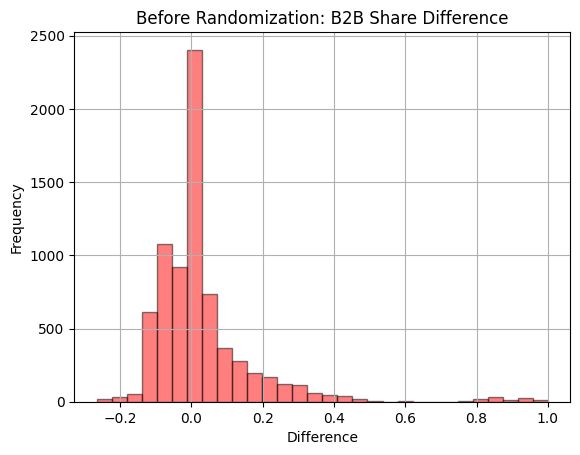

2025-04-11 12:14:15,959 - INFO - [Randomize B2B] Year: 2025 | Distance to base year: 4 | Normalized: 0.138 | Growth factor: 0.361 | Stddev: 0.0861
2025-04-11 12:14:15,974 - INFO - [Randomize B2B] Mean b2b_target changed from 0.2142 to 0.2286 (Δ = 0.0144)


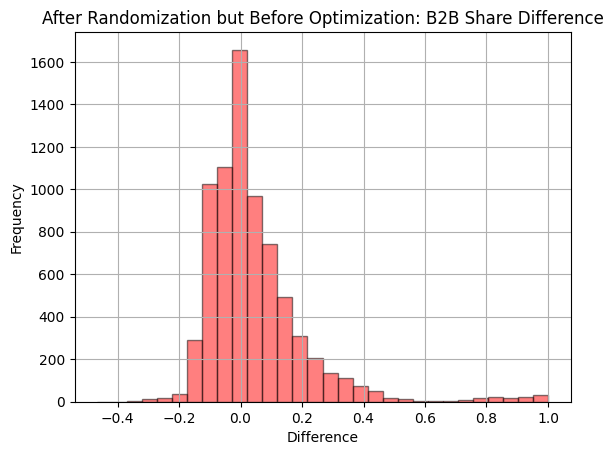

2025-04-11 12:14:16,314 - INFO - 
📊 B2B-Error Stats (Before All)
2025-04-11 12:14:16,315 - INFO -   → MAE:   0.1035
2025-04-11 12:14:16,316 - INFO -   → RMSE:  0.1686
2025-04-11 12:14:16,317 - INFO -   → Max:   1.0000
2025-04-11 12:14:16,317 - INFO -   → >0.2:  859 cells
2025-04-11 12:14:16,318 - INFO -   → >0.5:  135 cells
2025-04-11 12:14:17,898 - INFO - [Shifted] DHL: 3,002.0 B2B parcels reallocated
2025-04-11 12:14:19,478 - INFO - [Shifted] Hermes: 224.0 B2B parcels reallocated
2025-04-11 12:14:20,717 - INFO - [Shifted] UPS: 23.0 B2B parcels reallocated
2025-04-11 12:14:22,127 - INFO - [Shifted] DPD: 906.0 B2B parcels reallocated
2025-04-11 12:14:23,441 - INFO - [Shifted] GLS: 450.0 B2B parcels reallocated
2025-04-11 12:14:24,718 - INFO - [Shifted] FedEx/TNT: 4.0 B2B parcels reallocated
2025-04-11 12:14:25,919 - INFO - [Shifted] Amazon: 84.0 B2B parcels reallocated
2025-04-11 12:14:25,933 - INFO - 
📊 B2B-Error Stats (After preadjust)
2025-04-11 12:14:25,934 - INFO -   → MAE:   0.08

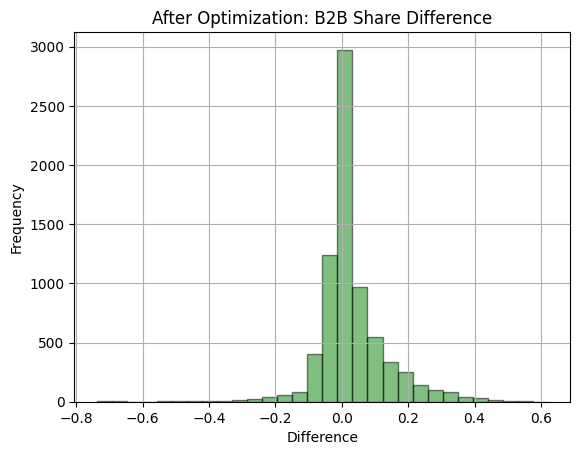

2025-04-11 12:14:31,224 - INFO - 📦 Global Parcel Distribution for 2025:
2025-04-11 12:14:31,225 - INFO -   B2B Parcels: 48,686  (21.60%)
2025-04-11 12:14:31,226 - INFO -   B2C Parcels: 176,706  (78.40%)
2025-04-11 12:14:31,226 - INFO -   Total:       225,392
2025-04-11 12:14:31,227 - INFO - 📊 Global Market Share per Carrier:
2025-04-11 12:14:31,229 - INFO -   DHL         : 40.79%
2025-04-11 12:14:31,239 - INFO -   DHL         : 91939
2025-04-11 12:14:31,242 - INFO -   Hermes      : 9.67%
2025-04-11 12:14:31,245 - INFO -   Hermes      : 21785
2025-04-11 12:14:31,248 - INFO -   UPS         : 9.21%
2025-04-11 12:14:31,249 - INFO -   UPS         : 20756
2025-04-11 12:14:31,251 - INFO -   DPD         : 8.11%
2025-04-11 12:14:31,256 - INFO -   DPD         : 18269
2025-04-11 12:14:31,258 - INFO -   GLS         : 6.78%
2025-04-11 12:14:31,259 - INFO -   GLS         : 15277
2025-04-11 12:14:31,262 - INFO -   FedEx/TNT   : 7.46%
2025-04-11 12:14:31,263 - INFO -   FedEx/TNT   : 16805
2025-04-11 1

In [46]:
import matplotlib.cm as cm

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# -------------------------
# Set the simulation date
# -------------------------
# Change this date to simulate a specific day.

# 🔢 Speichere alle df_compare pro Jahr zur Visualisierung
all_results = []
all_samples_distrubuted = []

for sim_date in [datetime.date(2025, 4, 9)]:

    simulation_date = sim_date
    logging.info(f"Simulation date: {simulation_date} ({simulation_date.strftime('%A')})")

    global_shares, df_market_share_by_plz = analyze_weighted_market_shares(
        gdf=ga_corrected_b2b_gdf,
        year=simulation_date.year
    )
    relative_package_change_per_day = get_relative_package_change_per_day(simulation_date, weekly_forecast_ci_df, model="linear")     

    parcel_estimation_per_cell = estimate_parcel_distribution_per_cell(
        gdf_cells=ga_corrected_b2b_gdf,
        df_market_share_by_plz=df_market_share_by_plz,
        relative_change = relative_package_change_per_day,
        alpha=50000,
        dhl_streets_df=dhl_streets_gdf,
        df_b2b_by_year = df_b2b_by_year,
        simulation_date=simulation_date
    )
    optimized_parcel_estimation_per_cell = adjust_b2b_distribution(ga_corrected_b2b_gdf, parcel_estimation_per_cell, simulation_date.year, global_shares, relative_package_change_per_day, rng)

    log_global_parcel_summary(
        gdf=ga_corrected_b2b_gdf,
        parcel_df=parcel_estimation_per_cell,
        year=simulation_date.year
    )

    df_samples = ensure_geometry_column(df_samples, geom_col="point_geom")
    samples_with_ratios = assign_cells_to_samples(df_samples, optimized_parcel_estimation_per_cell)

    samples_distributed = distribute_parcels_to_samples(
        samples_with_ratios=samples_with_ratios,
        parcel_estimation_per_cell=optimized_parcel_estimation_per_cell,
        rng = rng
    )

    samples_distributed["date"] = simulation_date
    df_compare, rmse, mean_geh = evaluate_distribution(samples_distributed, dhl_streets_gdf, plot = False)
    df_compare["date"] = simulation_date

    logging.info(f"RMSE to DHL 2021 Data: {rmse:.2f} Parcels per Street")
    logging.info(f"Mean GEH to DHL 2021 Data: {mean_geh:.2f} Parcels per Street")

    samples_distributed_points = samples_distributed.set_geometry("point_geom").copy()
    samples_distributed_points = samples_distributed_points.set_crs("EPSG:25832", inplace=True)

    # Alle weiteren Geometriespalten löschen (außer der aktiven)
    for col in samples_distributed_points.columns:
        if col != samples_distributed_points.geometry.name and isinstance(samples_distributed_points[col].iloc[0], shapely.geometry.base.BaseGeometry):
            del samples_distributed_points[col]

    # Formatieren: z. B. 2021-12-03_(Friday)
    date_for_filename = simulation_date.strftime("%Y-%m-%d_(%A)")
    # Dateipfad zusammenbauen
    filename_shape = f"output/parcel_demand_{date_for_filename}.shp"
    filename_gpkg = f"output/parcel_demand_{date_for_filename}.gpkg"

    log_carrier_market_shares(samples_distributed_points)

    logging.info("Writing distributed parcel samples to file: %s", filename_shape)   
    samples_distributed_points.to_file(driver='ESRI Shapefile', filename=filename_shape)
    logging.info("Writing distributed parcel samples to file: %s", filename_gpkg)
    samples_distributed_points.to_file(filename_gpkg, driver="GPKG")

    
    all_results.append(df_compare)
    all_samples_distrubuted.append(samples_distributed_points)



combined_results = pd.concat(all_results, ignore_index=True)
combined_distributed_samples = pd.concat(all_samples_distrubuted, ignore_index=True)




# 

In [30]:
samples_distributed_points

,sample_idx,str_idx,name,plz,b2c_ratio,b2b_ratio,point_geom,dhl_tag,cell_id,DHL_B2B,...,sum_b2b_sim,sum_b2c_sim,sum_b2b_ratio,sum_b2c_ratio,w_b2b_sim,w_b2c_sim,w_b2b_combined,w_b2c_combined,total_sim,date
0,0,0,Aegidienkirchhof,30159,199.5,29.92,POINT (550338.219 5802402.716),1,8611.0,0.0,...,1,17,846.37,1524.5,0.035351,0.130863,0.035351,0.130863,37,2025-04-09
1,1,0,Aegidienkirchhof,30159,50.5,24.80,POINT (550306.532 5802386.121),1,8611.0,0.0,...,0,3,846.37,1524.5,0.029302,0.033126,0.029302,0.033126,8,2025-04-09
2,2,1,Alexanderstraße,30159,23.5,38.98,POINT (550689.795 5802846.470),7,9179.0,0.0,...,0,1,821.78,525.0,0.047434,0.044762,0.047434,0.044762,1,2025-04-09
3,3,1,Alexanderstraße,30159,21.5,48.92,POINT (550728.041 5802877.929),7,9181.0,15.0,...,6,0,793.01,755.5,0.061689,0.028458,0.061689,0.028458,14,2025-04-09
4,4,1,Alexanderstraße,30159,4.5,19.20,POINT (550755.278 5802904.948),7,9181.0,15.0,...,5,0,793.01,755.5,0.024212,0.005956,0.024212,0.005956,12,2025-04-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112472,112472,12340,Ziegeleistraße,30855,28.0,21.00,POINT (546426.225 5809246.904),40,7431.0,12.0,...,12,2,178.20,246.0,0.117845,0.113821,0.117845,0.113821,29,2025-04-09
112473,112473,12340,Ziegeleistraße,30855,28.0,24.16,POINT (546376.247 5809245.455),40,7431.0,12.0,...,11,5,178.20,246.0,0.135578,0.113821,0.135578,0.113821,22,2025-04-09
112474,112474,12340,Ziegeleistraße,30855,22.0,22.09,POINT (546326.281 5809243.630),40,7061.0,6.0,...,2,1,563.98,566.0,0.039168,0.038869,0.039168,0.038869,7,2025-04-09
112475,112475,12340,Ziegeleistraße,30855,26.0,24.76,POINT (546277.971 5809241.176),40,7061.0,6.0,...,2,2,563.98,566.0,0.043902,0.045936,0.043902,0.045936,5,2025-04-09


(5795000.0, 5810000.0)

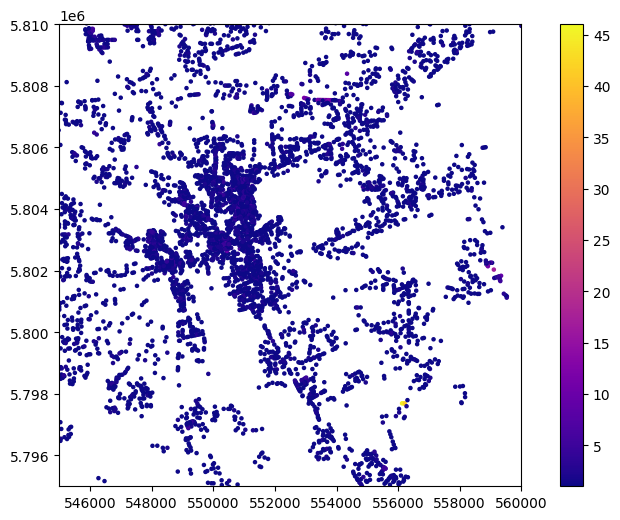

In [159]:
# Bounding Box für das Zentrum von Hannover (ungefähr, EPSG:25832)
xmin, xmax = 545000, 560000
ymin, ymax = 5795000, 5810000

# Nur Punkte mit DHL_b2b_sim > 0 anzeigen
nonzero = samples_distributed_points.query("DHL_b2b_sim > 0")


# Plot
ax = nonzero.plot(
    column="DHL_b2b_sim",
    cmap="plasma",
    legend=True,
    figsize=(10, 6),
    markersize=5
)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

In [132]:
def calculate_sgv(model: np.ndarray, observed: np.ndarray, f: float = 10000) -> np.ndarray:
    """
    Calculate the Scalable Quality Value (SQV) for model vs. observed data.

    Parameters:
    -----------
    model : array-like
        Model values (e.g., simulated parcels per street)
    observed : array-like
        Observed values (e.g., DHL tags per street)
    f : float
        Scaling factor depending on the magnitude of the metric

    Returns:
    --------
    SQV values between 0 and 1 (1 = perfect match)
    """
    model = np.array(model)
    observed = np.array(observed)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        diff_squared = (model - observed) ** 2
        denom = f * observed
        denom[denom == 0] = 1e-6  # avoid division by zero
        sqv = 1 / (1 + np.sqrt(diff_squared / denom))
    
    return sqv


df_compare["abs_perc_error"] = (
    df_compare["DHL_total"] - df_compare["dhl_tag"]
).abs() / df_compare["dhl_tag"].replace(0, np.nan)

mape = df_compare["abs_perc_error"].mean() * 100
print(f"🔍 MAPE: {mape:.2f} %")

rmse = np.sqrt(((df_compare["DHL_total"] - df_compare["dhl_tag"]) ** 2).mean())
print(f"📈 RMSE: {rmse:.2f} Pakete")

# GEH-Berechnung pro Straße
df_compare["GEH"] = np.sqrt(
    2 * (df_compare["DHL_total"] - df_compare["dhl_tag"])**2 / 
    (df_compare["DHL_total"] + df_compare["dhl_tag"]).replace(0, np.nan)  # Division durch 0 vermeiden
)

# Optional: NaNs durch 0 ersetzen (z. B. wenn beide Werte 0 waren)
df_compare["GEH"] = df_compare["GEH"].fillna(0)

# Statistik ausgeben
print("🔍 GEH-Auswertung:")
print(f"Mittlerer GEH:  {df_compare['GEH'].mean():.2f}")
print(f"Median GEH:     {df_compare['GEH'].median():.2f}")
print(f"Anteil GEH < 5: {(df_compare['GEH'] < 5).mean()*100:.1f}%")
print(f"Anteil GEH < 10: {(df_compare['GEH'] < 10).mean()*100:.1f}%")

df_compare["sqv_dhl"] = calculate_sgv(
    model=df_compare["DHL_total"].values,
    observed=df_compare["dhl_tag"].values,
    f=1000
)

print(f"🔍 Mittleres SQV für DHL: {df_compare['sqv_dhl'].mean():.3f}")

🔍 MAPE: 58.73 %
📈 RMSE: 7.59 Pakete
🔍 GEH-Auswertung:
Mittlerer GEH:  1.43
Median GEH:     1.41
Anteil GEH < 5: 99.0%
Anteil GEH < 10: 100.0%
🔍 Mittleres SQV für DHL: 0.941
